In [31]:
from sklearn import datasets
from sklearn.model_selection import KFold
# Load the TensorBoard notebook extension

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


class SimpleMLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fc_in = nn.Linear(in_features=4, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=7)
        self.fc_out = nn.Linear(in_features=7, out_features=n_classes)

    def forward(self, x, get_features=False):
        x = self.fc_in(x)
        x = F.relu(x)
        x = self.fc2(x)
        y = F.relu(x)
        x = self.fc_out(y)
        x = F.softmax(x, dim=1)
        if get_features:
            return x, y
        return x


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
    verbose=True,
):

    history = {
        "train": {"loss": [], "accuracy": []},
        "valid": {"loss": [], "accuracy": []},
    }
    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = 0
        total = 0
        evaluation_train = {"accuracy": 0, "loss": 0}
        for idx, data in enumerate(tqdm(train_loader,disable=not verbose)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)
            correct += accuracy(output, labels) * len(labels)
            total += len(labels)
        # Loss_history.append(Loss_epoch/n)
        evaluation_train["accuracy"] = correct / total
        evaluation_train["loss"] = Loss_epoch / total
        # evaluation_train = evaluate(model, train_loader,criterion, device)
        evaluation_valid, *_ = evaluate(model, valid_loader, criterion, device)
        if verbose:
            print(f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}")

        history["train"]["accuracy"].append(evaluation_train["accuracy"])
        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])
        history["valid"]["accuracy"].append(evaluation_valid["accuracy"])

        if log_writer is not None:
            log_writer.log(
                {
                    "train/train_loss": (evaluation_train["loss"],epoch),
                    "train/train_accuracy": (evaluation_train["accuracy"],epoch),
                    "val/valid_loss": (evaluation_valid["loss"],epoch),
                    "val/valid_accuracy": (evaluation_valid["accuracy"],epoch),
                }
            )

    return history


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def evaluate(model, data_loader, criterion, device, return_preds=False,return_features=False):
    model.eval()
    Accuracy_history = []
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)
            Accuracy_history.append(accuracy(output, target))
            Loss_history.append(loss.item())
            if return_preds:
                # PREDS.extend(torch.max(output, dim=1)[1].tolist())
                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return {
        "accuracy": torch.mean(torch.Tensor(Accuracy_history)).item(),
        "loss": torch.mean(torch.Tensor(Loss_history)).item(),
    }, PREDS , features , ground_truth

In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as tt
from sklearn.model_selection import train_test_split


class IRISDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x  # torch.Tensor(x,).unsqueeze(1).type(torch.FloatTensor)
        self.y = y  # torch.Tensor(y).type(torch.LongTensor)
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)

In [34]:
data = datasets.load_iris()
iris_X, iris_Y = data.data, data.target
classes = data.target_names
iris_X = iris_X.astype("float32")
iris_Y = iris_Y.astype("int64")

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
def get_features(model, data_loader, device,get_preds=False):
    model.eval()
    features = []
    labels = []
    preds = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            output = model(input, get_features=True)
            if get_preds:
                preds.extend(output[0].tolist())
            features.extend(output[1].tolist())
            labels.extend(target.tolist())
    return features, labels , preds

def plot_TSNE(X, Y, title, writer=None):
    X_embedded = TSNE(n_components=2, perplexity=min(20, len(X)), n_iter=1000).fit_transform(X)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    plt.title(f'kfold: {title}')
    plt.show()
    if writer is not None:
        writer.add_figure('TSNE', fig, global_step=0)
        # writer.close()
# classes = [0,1,2]
def add_pr_curve_tensorboard(class_index, classes,test_probs, test_label, writer, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    # writer.close()

def acc_pr_rec(preds, labels, classes, writer, global_step=0):
    preds = np.array(preds)
    labels = np.array(labels)
    preds_ = np.argmax(preds, axis=1)
    for i in range(len(classes)):
        add_pr_curve_tensorboard(i, classes, preds, labels, writer, global_step)
    writer.add_scalar('Accuracy',ac:=accuracy_score(labels,preds_),global_step=global_step)
    writer.add_scalar('Precision',pr:=precision_score(labels, preds_, average='weighted'),global_step=global_step)
    writer.add_scalar('Recall',rec:=recall_score(labels, preds_, average='weighted'),global_step=global_step)
    writer.add_scalar('F1',f1:=f1_score(labels, preds_, average='weighted'),global_step=global_step)
    writer.close()
    return ac,pr,rec,f1

def plot_ConfusionMatrix(preds, labels, classes, title,writer, global_step=0):
    cm = confusion_matrix(labels, np.argmax(preds,axis=1), normalize='true')
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    plt.title(f'kfold: {title}')
    plt.show()
    writer.add_figure('ConfusionMatrix',
                    fig  ,
                    global_step=global_step)
    writer.close()
    return cm

Kfold: 0


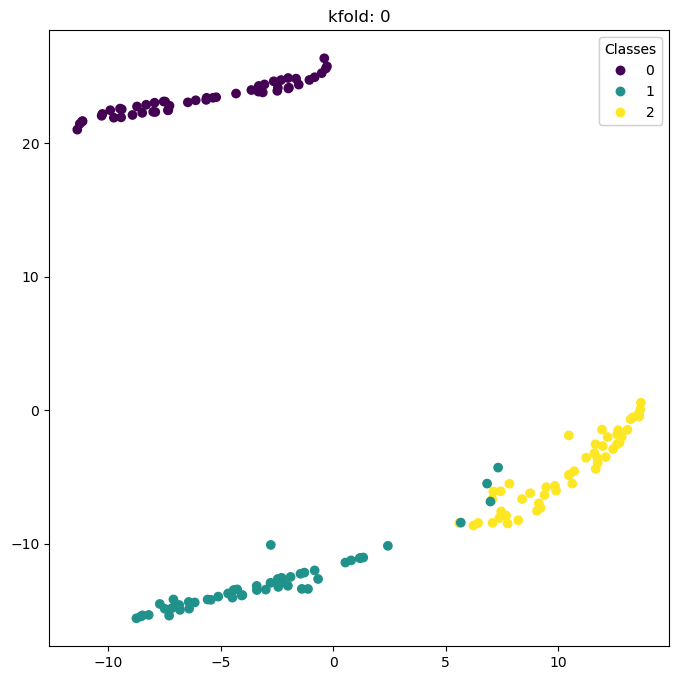

fold: 0
test accuracy: 1.0, test loss: 0.5724608302116394
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


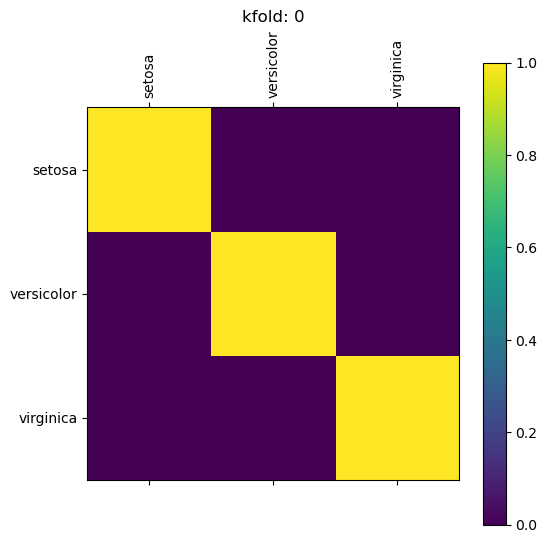

Kfold: 1


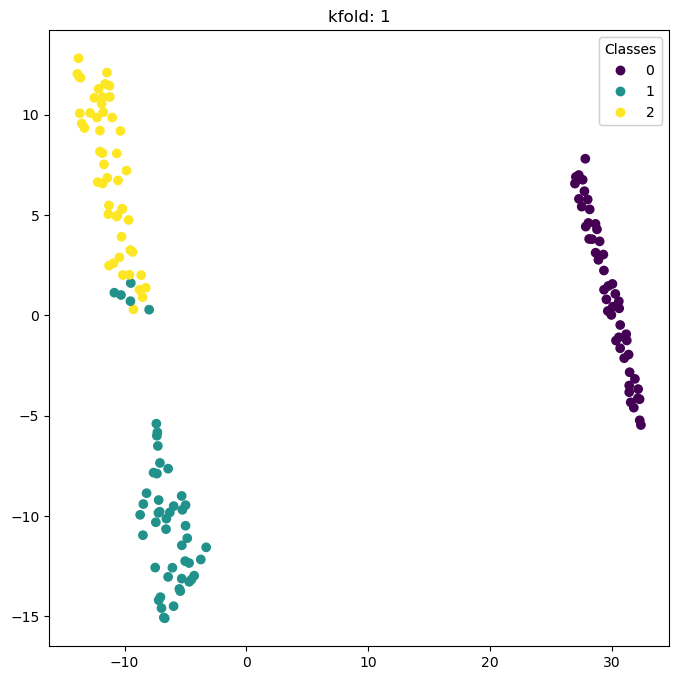

fold: 1
test accuracy: 1.0, test loss: 0.5571573972702026
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


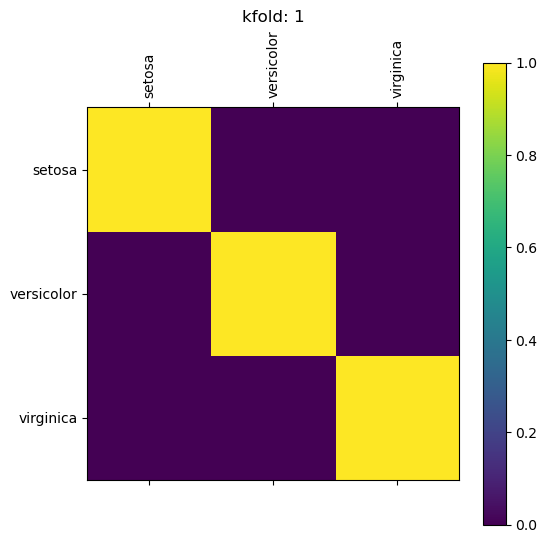

Kfold: 2


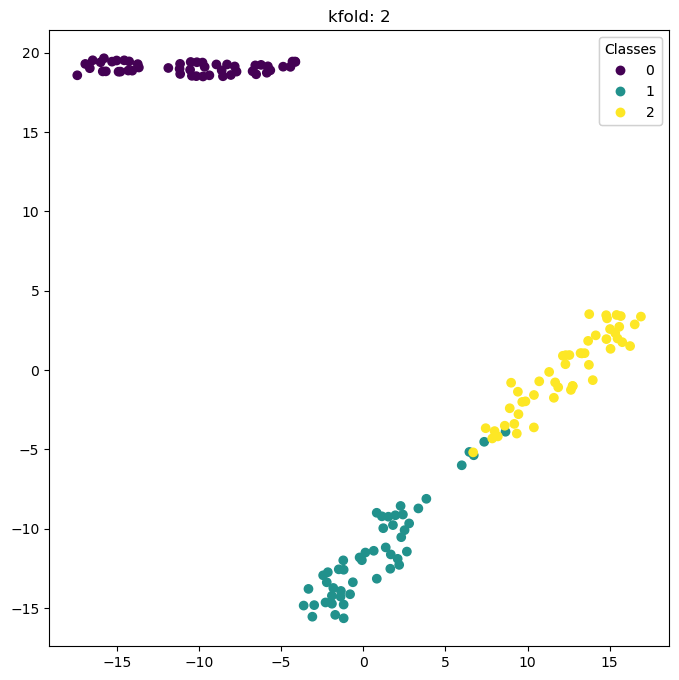

fold: 2
test accuracy: 1.0, test loss: 0.5524360537528992
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


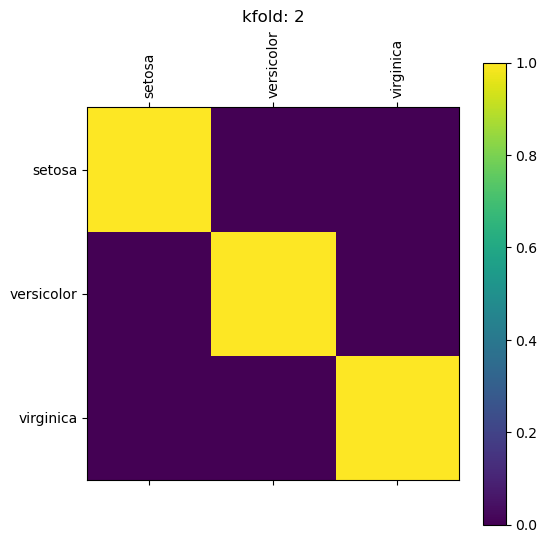

Kfold: 3


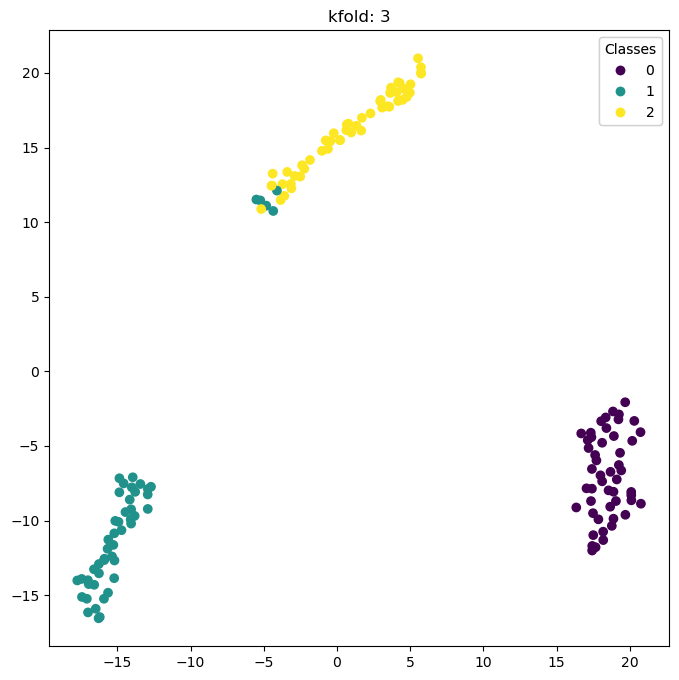

fold: 3
test accuracy: 0.9333333333333333, test loss: 0.6041681170463562
Precision: 0.9428571428571428, Recall: 0.9333333333333333, F1: 0.9321937321937322
--------------------


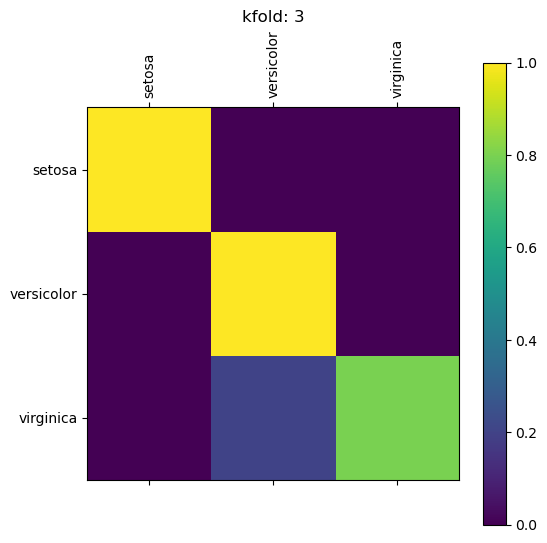

Kfold: 4


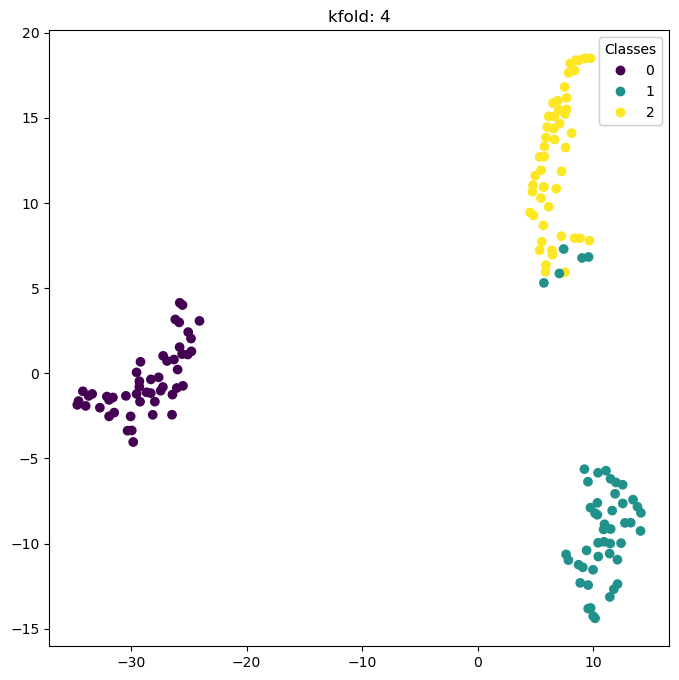

fold: 4
test accuracy: 1.0, test loss: 0.5679584741592407
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


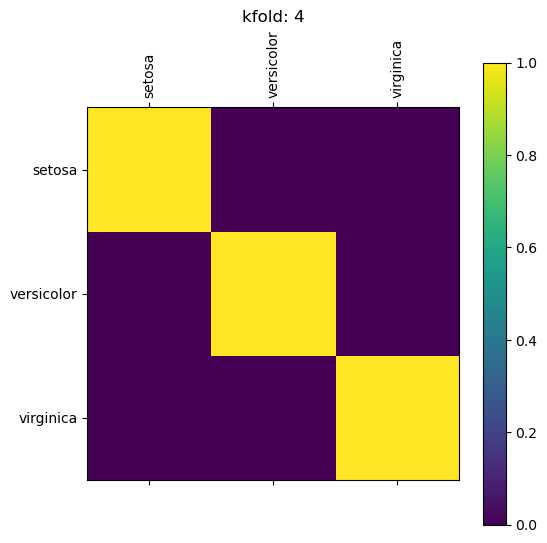

Kfold: 5


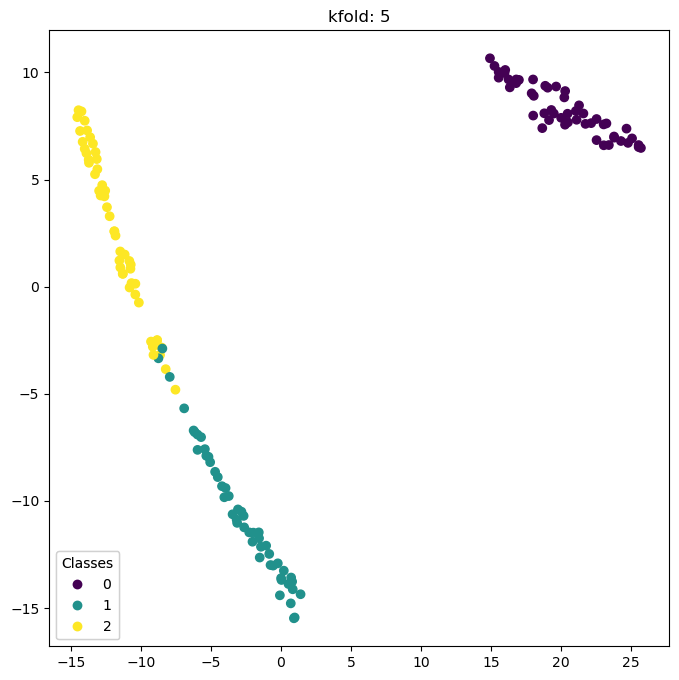

fold: 5
test accuracy: 0.9333333333333333, test loss: 0.6383800506591797
Precision: 0.95, Recall: 0.9333333333333333, F1: 0.9350649350649349
--------------------


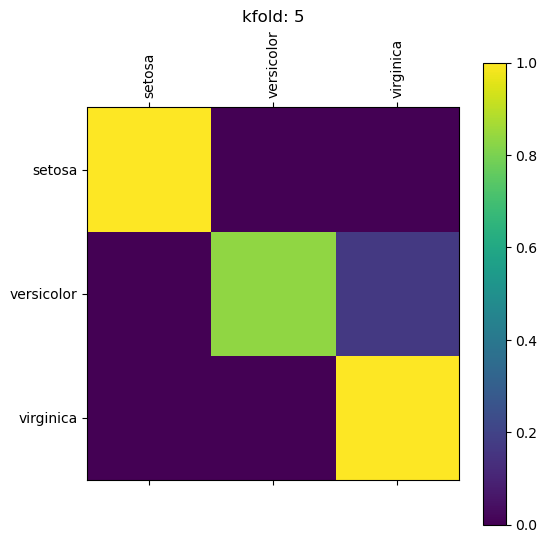

Kfold: 6


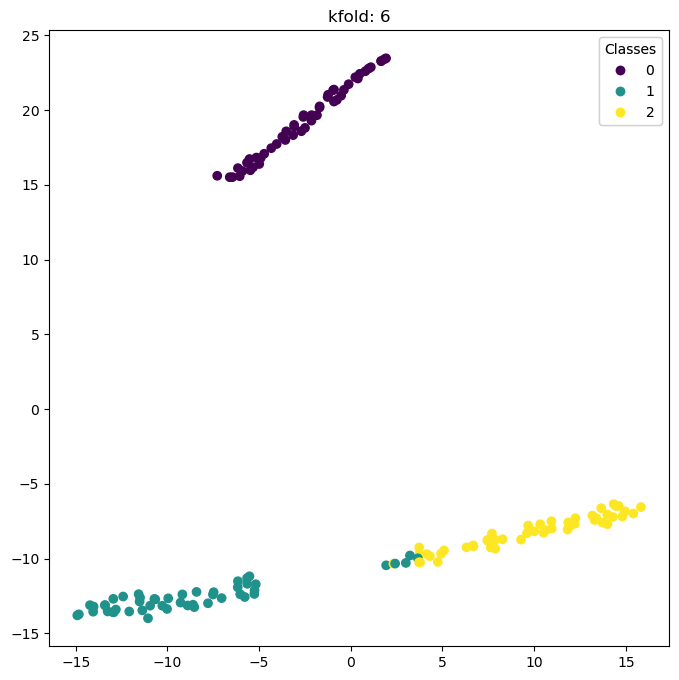

fold: 6
test accuracy: 0.9333333333333333, test loss: 0.6419510245323181
Precision: 0.9428571428571428, Recall: 0.9333333333333333, F1: 0.9311355311355312
--------------------


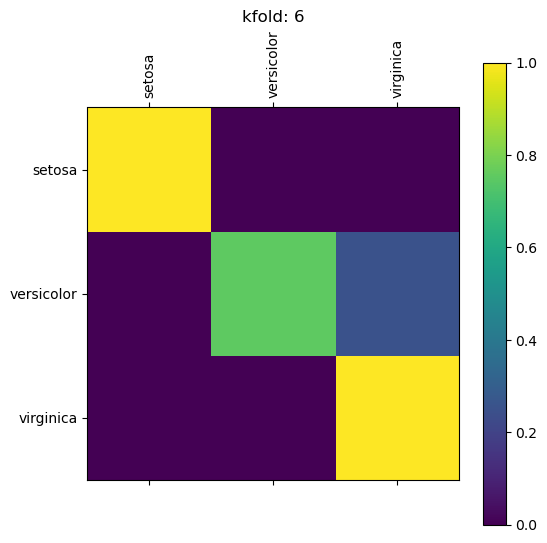

Kfold: 7


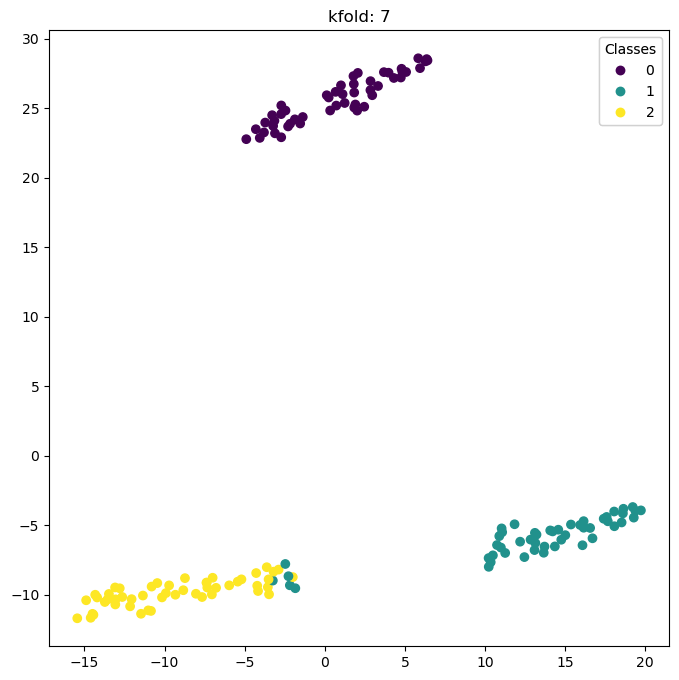

fold: 7
test accuracy: 1.0, test loss: 0.5624386668205261
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


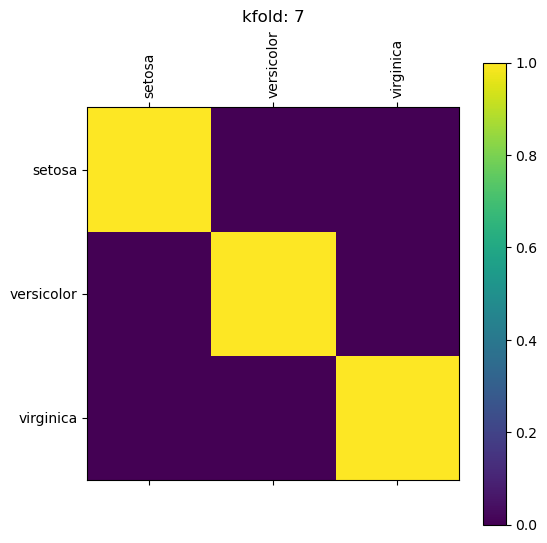

Kfold: 8


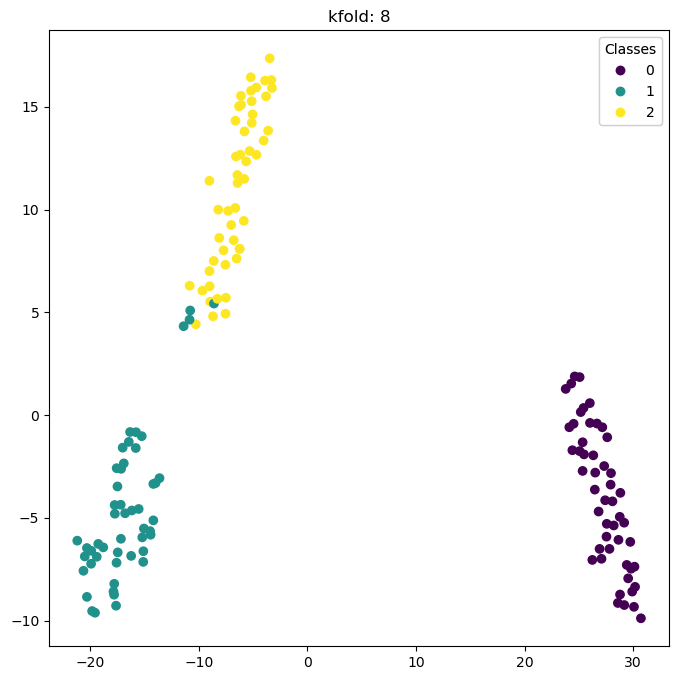

fold: 8
test accuracy: 1.0, test loss: 0.5606147646903992
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


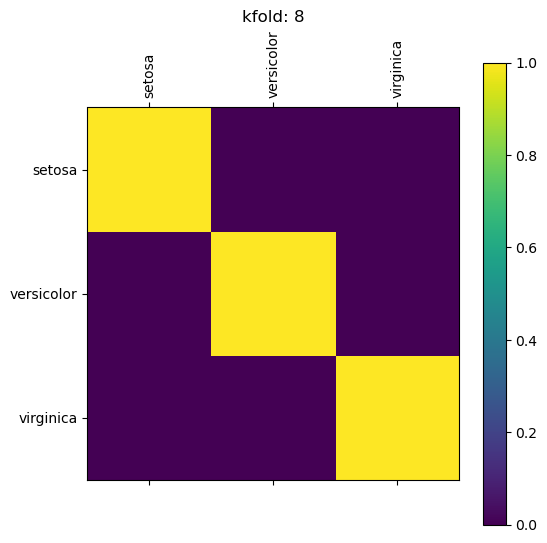

Kfold: 9


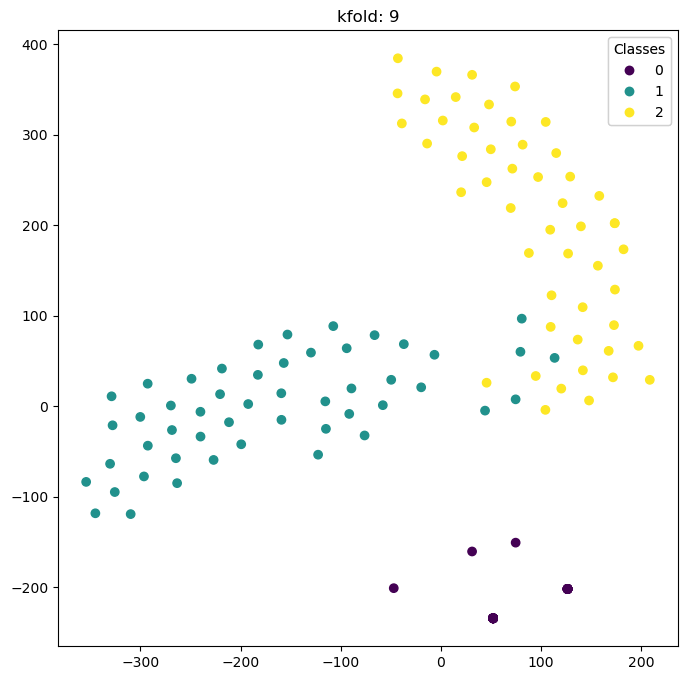

fold: 9
test accuracy: 1.0, test loss: 0.5649528503417969
Precision: 1.0, Recall: 1.0, F1: 1.0
--------------------


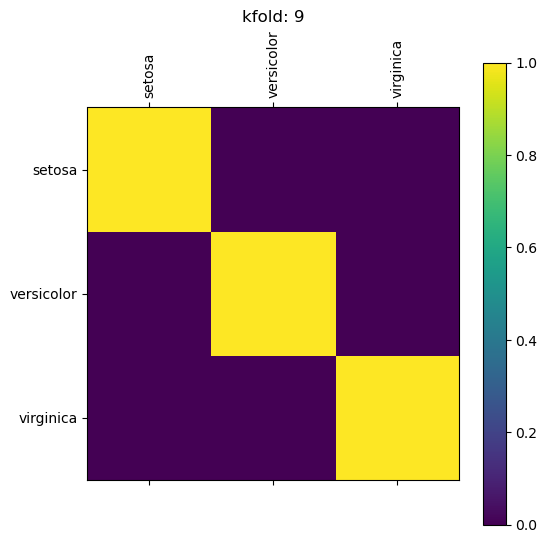

Average Accuracy: 0.9800000000000001, Average Loss: 0.5822518229484558, Average Precision: 0.9835714285714285, Average Recall: 0.9800000000000001


In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.manifold import TSNE

class custom_summary_writer:
    def __init__(self, writer):
        self.writer = writer

    def log(self, metrics):
        for key, value in metrics.items():
            self.writer.add_scalar(key, *(value))

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = make_pipeline(StandardScaler())

n_splits = 10
kFold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
Avg_Accuracy = 0
Avg_Loss = 0
Avg_Precision = 0
Avg_Recall = 0
for fold, (train_index, test_index) in enumerate(kFold.split(iris_X)):
    print(f"Kfold: {fold}")
    # if fold!=9:
    #     continue
    writer = custom_summary_writer(SummaryWriter(f"runs/iris_experiment_1/fold_{fold}"))

    X_train, X_test, y_train, y_test = (
        iris_X[train_index],
        iris_X[test_index],
        iris_Y[train_index],
        iris_Y[test_index],
    )

    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)




    X_train_dataset = IRISDataset(X_train, y_train, tt.Compose([torch.tensor]))
    X_test_dataset = IRISDataset(X_test, y_test, tt.Compose([torch.tensor]))

    train_loader = DataLoader(X_train_dataset, batch_size=10, shuffle=True)
    test_loader = DataLoader(X_test_dataset, batch_size=10, shuffle=False)


    model = SimpleMLP(len(classes))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    history = train(
        model, train_loader, test_loader, optimizer, criterion, device, epochs=25,log_writer = writer,verbose=False
    )

    features_train_data, train_labels , _ = get_features(model, train_loader, device)
    features_test_data, test_labels , test_preds = get_features(model, test_loader, device, get_preds=True)
    features = np.concatenate([features_train_data,features_test_data])
    labels = np.concatenate([train_labels,test_labels])
    plot_TSNE(features, labels,title=fold,writer=writer.writer)
    

    loss_test = criterion(torch.tensor(test_preds), torch.tensor(test_labels)).item()
    ac, pr, rec, f1 = acc_pr_rec(test_preds, test_labels, classes, writer.writer)
    print(f'fold: {fold}')
    print(f"test accuracy: {ac}, test loss: {loss_test}")
    print(f"Precision: {pr}, Recall: {rec}, F1: {f1}")
    print("-"*20)
    Avg_Accuracy += ac
    Avg_Loss += loss_test
    Avg_Precision += pr
    Avg_Recall += rec

    cm = plot_ConfusionMatrix(test_preds, test_labels, classes,fold ,writer.writer)


    writer.writer.close()
print(f"Average Accuracy: {Avg_Accuracy/n_splits}, Average Loss: {Avg_Loss/n_splits}, Average Precision: {Avg_Precision/n_splits}, Average Recall: {Avg_Recall/n_splits}") 